# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py


pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Import and set-up

Import the library and toy data

In [2]:
import pyxpcm
from pyxpcm.models import pcm

# Load a dataset to work with:
ds = pyxpcm.tutorial.open_dataset('argo').load()

# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

## Debugging

Use option ``debug`` to print log messages 

In [3]:
# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds);

> Start preprocessing for action 'fit'



	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'


	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in the input axis, not need to interpolate, simple intersection
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))] X INTERPOLATED with success)


	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X SCALED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X REDUCED with success)
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'


	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in the input axis, not need to interpolate, simple intersection
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))] X INTERPOLATED with success)


	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X SCALED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X REDUCED with success)
	salinity pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of salinity
	Features array shape and type for xarray: (7560, 30) <class 'numpy.ndarray'> <class 'memoryview'>
> Preprocessing done, working with final X (<class 'xarray.core.dataarray.DataArray'>) array of shape: (7560, 30)  and sampling dimensions: ['N_PROF']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings during execution

In [4]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=1)
m.fit(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 33 ms


  fit.1-preprocess.2-feature_temperature.1-ravel: 247 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 1 ms


  fit.1-preprocess.2-feature_temperature.3-scale_fit: 449 ms


  fit.1-preprocess.2-feature_temperature.4-scale_transform: 222 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 19 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 4 ms
  fit.1-preprocess.2-feature_temperature.total: 946 ms
  fit.1-preprocess: 946 ms
  fit.1-preprocess.3-homogeniser: 1 ms


  fit.1-preprocess.2-feature_salinity.1-ravel: 227 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 1 ms


  fit.1-preprocess.2-feature_salinity.3-scale_fit: 458 ms


  fit.1-preprocess.2-feature_salinity.4-scale_transform: 224 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 16 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 4 ms
  fit.1-preprocess.2-feature_salinity.total: 933 ms
  fit.1-preprocess: 933 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 1919 ms


  fit.2-fit: 1751 ms
  fit.3-score: 14 ms
  fit: 3685 ms


### A posteriori Execution time analysis

In [5]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=0)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [6]:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   42.706251
                           2-feature_temperature  1-ravel                269.489050
                                                  2-interp                 1.130104
                                                  3-scale_fit            434.630156
                                                  4-scale_transform      228.902102
                                                  5-reduce_fit            18.913984
                                                  6-reduce_transform       3.831863
                                                  total                  957.070112
                           total                                        4118.751287
                           3-homogeniser          total                    2.233028
                           2-feature_salinity     1-ravel                260.258198
       

## Visualisation help

### Main steps by method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-score,6-xarray,score
Method,,,,,,,,,
fit,8235.534430,2538.093090,NaN,15.496969,NaN,NaN,NaN,NaN,NaN
fit_predict,3996.393204,2523.284197,NaN,25.204897,NaN,10.256767,12.607098,526.827097,NaN
predict,5253.793001,NaN,13.623238,NaN,457.260847,NaN,NaN,NaN,16.039133


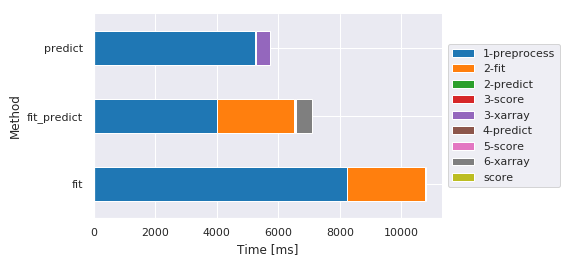

In [7]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Preprocessing main steps by method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,42.706251,2156.672478,1913.967371,2.233028,1.204014
fit_predict,25.602102,951.732635,1016.837597,2.020597,1.220226
predict,29.098988,979.947805,1615.144014,0.807047,1.107931


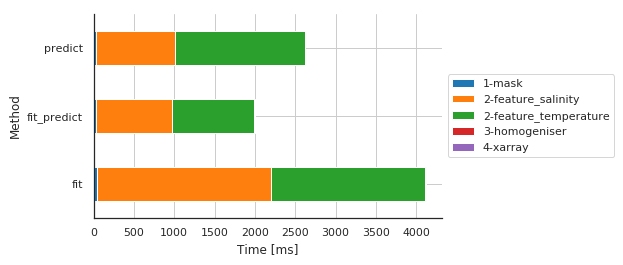

In [8]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Preprocessing details by method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,529.747248,3.009081,962.048054,498.774290,34.006119,7.555962
fit_predict,443.938971,2.353907,0.003338,529.563189,0.005007,8.283138
predict,583.785772,3.417015,0.020266,703.068972,0.002146,7.056713


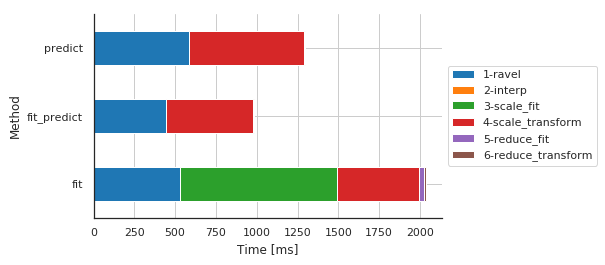

In [9]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Preprocessing details by features

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.723540,0.004211,0.527422,0.763633,0.015096,0.010015
2-feature_temperature,0.833932,0.004569,0.434649,0.967773,0.018917,0.012881


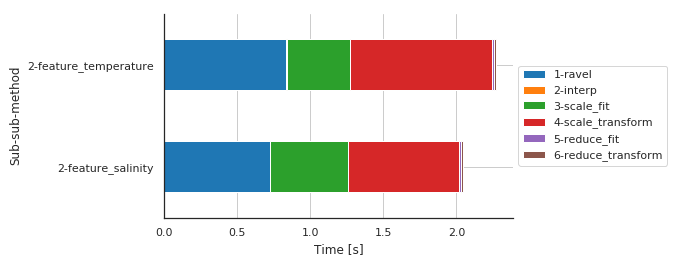

In [10]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df